# Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan

### Installing and loading necessary packages

In [1]:
install.packages("rgl", repos = "http://cran.rstudio.com/")
install.packages("ConsRank", repos = "http://cran.rstudio.com/")
library("ConsRank")
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")
install.packages('ggmap')
install.packages('codetools')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rgl

This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).


Attaching package: ‘ConsRank’


The following object is masked from ‘package:base’:

    labels


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
options(repr.plot.width  = 3,
        repr.plot.height = 3)
Sys.setenv(USE_CXX14 = 1)
library("rstan") # observe startup messages
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [5]:
install.packages("reshape2")
library(reshape2)
library(ggplot2)
install.packages("ggthemes")
library(ggthemes)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# if needed to uncomment the import of these packages
# We think they might overwrite the extract() function from rstan
# be careful

#install.packages("tidyverse")
#library(tidyverse)
#install.packages('gridExtra')
#library(gridExtra)

## Loading data and analyzing it

Uploading dataset of data collected from 1900-1921 from pelts collected from Canadian Lynxes and Snowshoe Hares.

In [3]:
lynx_hare_df <-
  read.csv("hudson-bay-lynx-hare.csv",
           comment.char="#")

### Data Analysis

Analyising input dataframe and plotting the population dynamics betweeen the 2 populations to observe how they follow the typical oscilations.

In [6]:
lynx_hare_melted_df <- melt(as.matrix(lynx_hare_df[, 2:3]))
colnames(lynx_hare_melted_df) <- c("year", "species", "pelts")
lynx_hare_melted_df$year <-
  lynx_hare_melted_df$year +
  rep(1899, length(lynx_hare_melted_df$year))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


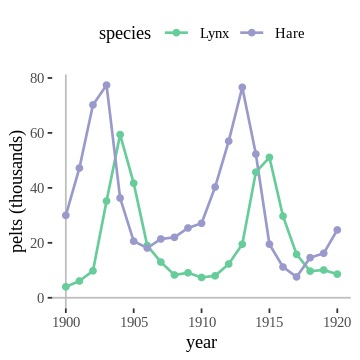

In [7]:
data_analysis_plot <- ggplot(data = lynx_hare_melted_df,
       aes(x = year, y = pelts, color = species)) +
geom_vline(xintercept = 1900, color = "grey") +
geom_hline(yintercept = 0, color = "grey") +
geom_line(size = 0.75) +
geom_point(size = 1.5) +
ylab("pelts (thousands)")+
theme_tufte()+
theme(legend.position="top")+
scale_color_manual(values = c("Lynx" = "#66CC99", "Hare" = "#9999CC"))


data_analysis_plot

In [8]:
ggsave("og_data_plot.png", plot = data_analysis_plot, width = 5, height = 3, dpi = 300)

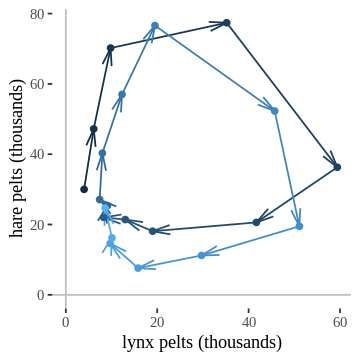

In [9]:
position_plot <- ggplot(data = lynx_hare_df,
       aes(x = Lynx, y = Hare, color = Year)) +
geom_vline(xintercept = 0, color = "grey") +
geom_hline(yintercept = 0, color = "grey") +
geom_path(arrow = arrow(angle = 15, length = unit(0.15, "inches"))) +
geom_point(size = 1.5) +
xlab("lynx pelts (thousands)") +
ylab("hare pelts (thousands)") +
theme_tufte() +
theme(legend.position="none")

position_plot

In [10]:
ggsave("position_plot.png", plot = position_plot, width = 5, height = 3, dpi = 300)

# Bayesian Inference from Predator-Pray Population Dynamics in Stan

## Fitting first simple model

We are going to infere the posterior distribution using stan.

In [11]:
scode = "
functions {
  array[] real dz_dt(real t, // time
                     array[] real z,
                     // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N] real ts; // measurement times > 0
  array[2] real y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  array[4] real<lower=0> theta; // { alpha, beta, gamma, delta }
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}
transformed parameters {
  array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}
"

In [12]:
# model is translated to C++ and compiled.
model <- stan_model(model_code = scode)

In [13]:
N <- length(lynx_hare_df$Year) - 1
ts <- 1:N
y_init <- c(lynx_hare_df$Hare[1], lynx_hare_df$Lynx[1])
y <- as.matrix(lynx_hare_df[2:(N + 1), 2:3])
y <- cbind(y[ , 2], y[ , 1]); # hare, lynx order
lynx_hare_data <- list(N = N, ts = ts, y_init = y_init, y = y)

In [14]:
fit <- sampling(model, data = lynx_hare_data, seed = 123)

In [15]:
print(fit, pars=c("theta", "sigma", "z_init"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.546   0.002 0.065  0.465  0.544  0.630  1011 1.002
theta[2]   0.028   0.000 0.004  0.023  0.027  0.033  1077 1.003
theta[3]   0.802   0.003 0.093  0.688  0.796  0.920   977 1.003
theta[4]   0.024   0.000 0.004  0.020  0.024  0.029  1026 1.003
sigma[1]   0.249   0.001 0.044  0.199  0.243  0.307  2685 1.000
sigma[2]   0.250   0.001 0.044  0.202  0.244  0.306  2662 1.000
z_init[1] 33.984   0.054 2.918 30.353 33.907 37.897  2952 1.001
z_init[2]  5.946   0.011 0.524  5.305  5.917  6.621  2177 0.999

Samples were drawn using NUTS(diag_e) at Wed Jun 12 20:06:26 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The $\hat{R}$ values are all close to 1, indicating convergence. The effective sample size estimates for each parameter are adequate for inference. With effective sample sizes of approximately one thousand, standard errors are roughly one thirtieth the size of posterior standard deviations, due to the inverse square root relationship. Therefore, we can be confident that Stan has provided an accurate approximation of the posterior distribution.

### Posterior Predictive Checks

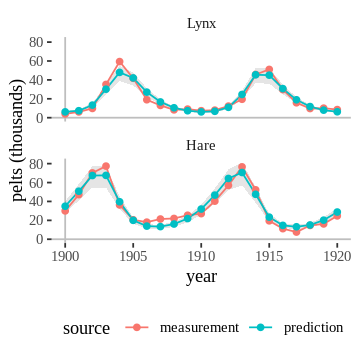

In [16]:
z_init_draws <- extract(fit)$z_init
z_draws <- extract(fit)$z
y_init_rep_draws <- extract(fit)$y_init_rep
y_rep_draws <- extract(fit)$y_rep
predicted_pelts <- matrix(NA, 21, 2)
min_pelts <- matrix(NA, 21, 2)
max_pelts <- matrix(NA, 21, 2)
for (k in 1:2) {
  predicted_pelts[1, k] <- mean(y_init_rep_draws[ , k])
  min_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.25)
  max_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.75)
  for (n in 2:21) {
    predicted_pelts[n, k] <- mean(y_rep_draws[ , n - 1, k])
    min_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.25)
    max_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.75)
  }
}

lynx_hare_melted_df <- melt(as.matrix(lynx_hare_df[, 2:3]))
colnames(lynx_hare_melted_df) <- c("year", "species", "pelts")
lynx_hare_melted_df$year <-
  lynx_hare_melted_df$year +
  rep(1899, length(lynx_hare_melted_df$year))

Nmelt <- dim(lynx_hare_melted_df)[1]
lynx_hare_observe_df <- lynx_hare_melted_df
lynx_hare_observe_df$source <- rep("measurement", Nmelt)

lynx_hare_predict_df <-
  data.frame(year = rep(1900:1920, 2),
             species = c(rep("Lynx", 21), rep("Hare", 21)),
             pelts = c(predicted_pelts[, 2],
                       predicted_pelts[, 1]),
             min_pelts = c(min_pelts[, 2], min_pelts[, 1]),
             max_pelts = c(max_pelts[, 2], max_pelts[, 1]),
             source = rep("prediction", 42))

lynx_hare_observe_df$min_pelts = lynx_hare_predict_df$min_pelts
lynx_hare_observe_df$max_pelts = lynx_hare_predict_df$max_pelts

lynx_hare_observe_predict_df <-
  rbind(lynx_hare_observe_df, lynx_hare_predict_df)

population_plot2 <-
  ggplot(data = lynx_hare_observe_predict_df,
         aes(x = year, y = pelts, color = source)) +
  geom_vline(xintercept = 1900, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  facet_wrap( ~ species, ncol = 1) +
  geom_ribbon(aes(ymin = min_pelts, ymax = max_pelts),
	      colour = NA, fill = "black", alpha = 0.1) +
  geom_line() +
  geom_point() +
  ylab("pelts (thousands)") +
  theme_tufte()+
  theme(legend.position="bottom")

population_plot2

In [17]:
ggsave("posterior_inference.png", plot = population_plot2, width = 5, height = 3, dpi = 300)

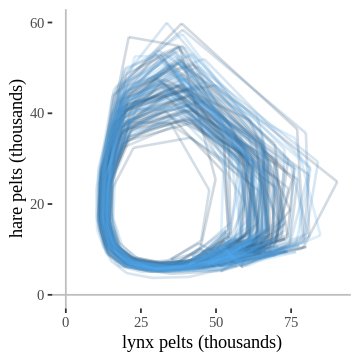

In [18]:
ss <- extract(fit)
df <- data.frame(list(lynx = ss$z[1, 1:12 , 1], hare = ss$z[1, 1:12, 2], draw = 1))
for (m in 2:100) {
  df <- rbind(df, data.frame(list(lynx = ss$z[m, 1:12 , 1], hare = ss$z[m, 1:12, 2], draw = m)))
}
plot <- ggplot(df) +
  geom_vline(xintercept = 0, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  geom_path(aes(x = lynx, y = hare, colour = draw), size = 0.75, alpha = 0.2) +
#  geom_point(size = 1.25) +
  xlab("lynx pelts (thousands)") +
  ylab("hare pelts (thousands)") +
  theme_tufte() +
  theme(legend.position="none")
plot

In [ ]:
ggsave("position_plot2.png", plot = plot, width = 5, height = 3, dpi = 300)

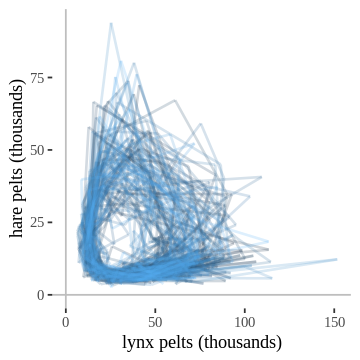

In [ ]:
ss <- extract(fit)
df <- data.frame(list(lynx = ss$y_rep[1, 1:12 , 1], hare = ss$y_rep[1, 1:12, 2], draw = 1))
for (m in 2:100) {
  df <- rbind(df, data.frame(list(lynx = ss$y_rep[m, 1:12 , 1], hare = ss$y_rep[m, 1:12, 2], draw = m)))
}
plot <- ggplot(df) +
  geom_vline(xintercept = 0, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  geom_path(aes(x = lynx, y = hare, colour = draw), size = 0.75, alpha = 0.2) +
  xlab("lynx pelts (thousands)") +
  ylab("hare pelts (thousands)") +
  theme_tufte() +
  theme(legend.position="none")
plot

In [ ]:
ggsave("with_uncertainty.png", plot = plot, width = 5, height = 3, dpi = 300)

## Mofications for forecasting

In this section, we perform forecasting based on the posterior inference. In order to do so we have to modify the original Stan code.

In [ ]:
#Modified Stan Code

scode = "
functions {
  array[] real dz_dt(real t, // time
                     array[] real z,
                     // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N+50] real ts; // measurement times > 0
  array[2] real y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  array[4] real<lower=0> theta; // { alpha, beta, gamma, delta }
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}
transformed parameters {
  array[N+50, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ :N , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N+50, 2] real y_rep;

  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : (N+50)) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}"

*It takes 8 mins to run this.*

In [ ]:
model1 = stan_model(model_code=scode)

In [ ]:
N <- length(lynx_hare_df$Year) - 1
ts <- 1:(N+50)
y_init <- c(lynx_hare_df$Hare[1], lynx_hare_df$Lynx[1])
y <- as.matrix(lynx_hare_df[2:(N + 1), 2:3])
y <- cbind(y[ , 2], y[ , 1]); # hare, lynx order
lynx_hare_data <- list(N = N, ts = ts, y_init = y_init, y = y)


fit <- sampling(model1, data = lynx_hare_data, seed = 123)

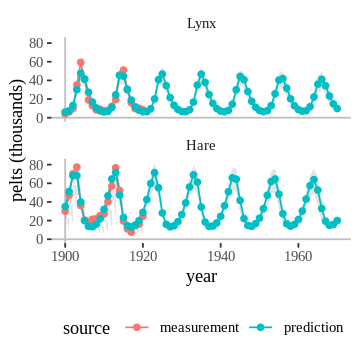

In [ ]:
z_init_draws <- extract(fit)$z_init
z_draws <- extract(fit)$z
y_init_rep_draws <- extract(fit)$y_init_rep
y_rep_draws <- extract(fit)$y_rep
predicted_pelts <- matrix(NA, 21+50, 2)
min_pelts <- matrix(NA, 21+50, 2)
max_pelts <- matrix(NA, 21+50, 2)
for (k in 1:2) {
  predicted_pelts[1, k] <- mean(y_init_rep_draws[ , k])
  min_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.25)
  max_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.75)
  for (n in 2:(21+50)) {
    predicted_pelts[n, k] <- mean(y_rep_draws[ , n - 1, k])
    min_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.25)
    max_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.75)
  }
}

lynx_hare_melted_df <- melt(as.matrix(lynx_hare_df[, 2:3]))
colnames(lynx_hare_melted_df) <- c("year", "species", "pelts")
lynx_hare_melted_df$year <-
  lynx_hare_melted_df$year +
  rep(1899, length(lynx_hare_melted_df$year))

Nmelt <- dim(lynx_hare_melted_df)[1]
lynx_hare_observe_df <- lynx_hare_melted_df
lynx_hare_observe_df$source <- rep("measurement", Nmelt)

lynx_hare_predict_df1 <-
  data.frame(year = rep(1900:1970, 2),
             species = c(rep("Lynx", 21+50), rep("Hare", 21+50)),
             pelts = c(predicted_pelts[, 2],
                       predicted_pelts[, 1]),
             min_pelts = c(min_pelts[, 2], min_pelts[, 1]),
             max_pelts = c(max_pelts[, 2], max_pelts[, 1]),
             source = rep("prediction", 142))

lynx_hare_observe_df$min_pelts = lynx_hare_predict_df1$min_pelts[1:42]
lynx_hare_observe_df$max_pelts = lynx_hare_predict_df1$max_pelts[1:42]

lynx_hare_observe_predict_df1 <-
  rbind(lynx_hare_observe_df, lynx_hare_predict_df1)

population_plot2 <-
  ggplot(data = lynx_hare_observe_predict_df1,
         aes(x = year, y = pelts, color = source)) +
  geom_vline(xintercept = 1900, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  facet_wrap( ~ species, ncol = 1) +
  geom_ribbon(aes(ymin = min_pelts, ymax = max_pelts),
	      colour = NA, fill = "black", alpha = 0.1) +
  geom_line() +
  geom_point() +
  ylab("pelts (thousands)") +
  theme_tufte() +
  theme(legend.position="bottom")

population_plot2

In [ ]:
ggsave("lynx_hare_plot.png", plot = population_plot2, width = 10, height = 6, dpi = 300)

## Prior analysis

### Modifying sigma parameters

In [ ]:
# Define the original Stan code as a string
scode <- "
functions {
  array[] real dz_dt(real t, // time
                     array[] real z,
                     // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N] real ts; // measurement times > 0
  array[2] real y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  array[4] real<lower=0> theta; // { alpha, beta, gamma, delta }
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}
transformed parameters {
  array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}
"

In [ ]:
# Different sigma values to test
sigma_values <- c(
  "sigma ~ lognormal(-1, 1);",
  "sigma ~ lognormal(-0.5, 0.5);",
  "sigma ~ lognormal(0, 0.5);",
  "sigma ~ lognormal(0.5, 1);"
)

In [ ]:
# Loop through the sigma values and fit the model
fits <- list()

for (i in seq_along(sigma_values)) {
  modified_scode <- gsub("sigma ~ lognormal\\(-1, 1\\);", sigma_values[i], scode)

  # Compile the model
  model <- stan_model(model_code = modified_scode)

  # Fit the model
  fit <- sampling(model, data = lynx_hare_data, seed = 123)
  fits[[i]] <- fit

  # Print fit summary
  #print(summary(fit)$summary)
  print(fit, pars=c("theta", "sigma", "z_init"),
      probs=c(0.1, 0.5, 0.9), digits = 3)
}

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.546   0.002 0.065  0.465  0.544  0.630  1011 1.002
theta[2]   0.028   0.000 0.004  0.023  0.027  0.033  1077 1.003
theta[3]   0.802   0.003 0.093  0.688  0.796  0.920   977 1.003
theta[4]   0.024   0.000 0.004  0.020  0.024  0.029  1026 1.003
sigma[1]   0.249   0.001 0.044  0.199  0.243  0.307  2685 1.000
sigma[2]   0.250   0.001 0.044  0.202  0.244  0.306  2662 1.000
z_init[1] 33.984   0.054 2.918 30.353 33.907 37.897  2952 1.001
z_init[2]  5.946   0.011 0.524  5.305  5.917  6.621  2177 0.999

Samples were drawn using NUTS(diag_e) at Wed Jun 12 17:52:46 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model.

No id variables; using all as measure variables



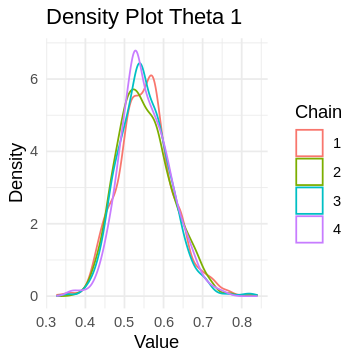

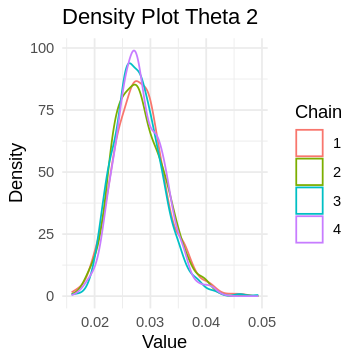

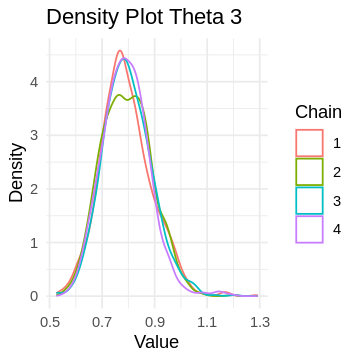

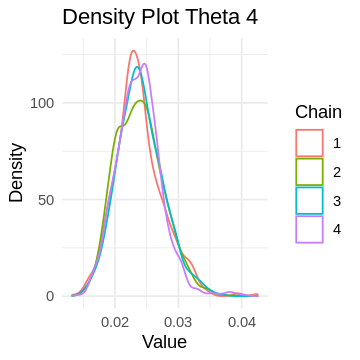

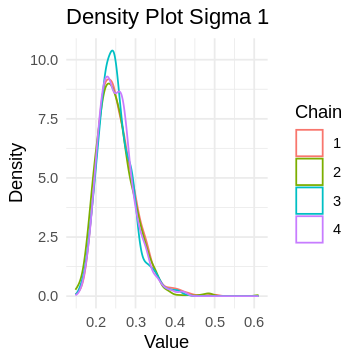

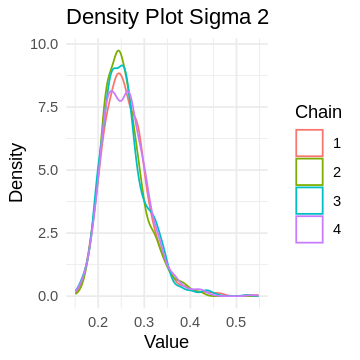

TableGrob (3 x 2) "arrange": 6 grobs
                                        z     cells    name            grob
theta[1]_theta[2]_theta[3]_theta[4]     1 (1-1,1-1) arrange gtable[arrange]
theta[5]_theta[6]_theta[7]_theta[8]     2 (1-1,2-2) arrange gtable[arrange]
theta[9]_theta[10]_theta[11]_theta[12]  3 (2-2,1-1) arrange gtable[arrange]
theta[13]_theta[14]_theta[15]_theta[16] 4 (2-2,2-2) arrange gtable[arrange]
sigma[1]_sigma[2]_sigma[3]_sigma[4]     5 (3-3,1-1) arrange gtable[arrange]
sigma[5]_sigma[6]_sigma[7]_sigma[8]     6 (3-3,2-2) arrange gtable[arrange]


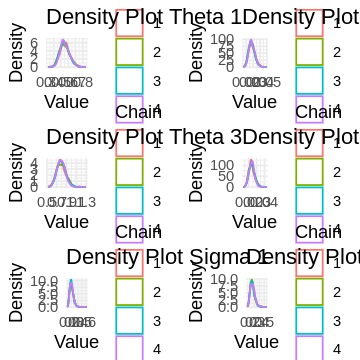

In [ ]:
library(ggplot2)
library(reshape2)

# Assuming 'fit' is your Stan model fit object
# Extract theta and sigma samples
theta_samples <- as.array(fits[[4]], pars = "theta")
sigma_samples <- as.array(fits[[4]], pars = "sigma")

# Combine the samples into a single data frame
theta_df <- as.data.frame(theta_samples)
sigma_df <- as.data.frame(sigma_samples)

# Rename columns for clarity
colnames(theta_df) <- paste0("theta[", 1:ncol(theta_df), "]")
colnames(sigma_df) <- paste0("sigma[", 1:ncol(sigma_df), "]")

# Combine theta and sigma data frames
samples_df <- cbind(theta_df, sigma_df)

# Convert the samples to long format for ggplot using melt
samples_long <- melt(samples_df)

# Rename columns for better readability
colnames(samples_long) <- c("parameter", "value")

# Add an iteration column for the trace plot
samples_long$iteration <- rep(1:nrow(samples_df), times = ncol(samples_df))

# Create a list to store plots
plots_list <- list()

# Define the number of chains
num_chains <- 4

# Define counters for theta and sigma
theta_count <- 1
sigma_count <- 1

# Loop through each parameter group
for (i in seq(1, ncol(samples_df), by = num_chains)) {
  # Get parameter group
  param_group <- names(samples_df)[i:(i + num_chains - 1)]

  # Create empty data frames for trace and density plots
  trace_data <- data.frame()
  density_data <- data.frame()

  # Loop through each parameter in the group
  for (param in param_group) {
    # Filter samples for the parameter
    parameter_samples <- subset(samples_long, parameter == param)

    # Add chain number to samples
    parameter_samples$chain <- rep(1:num_chains, each = nrow(parameter_samples) / num_chains)

    # Append data to trace and density data frames
    trace_data <- rbind(trace_data, parameter_samples)
    density_data <- rbind(density_data, parameter_samples)
  }

  # Create density plot for the parameter group
  density_plot <- ggplot(density_data, aes(x = value, color = factor(chain))) +
    geom_density(size = 0.5) +
    labs(x = "Value", y = "Density", color = "Chain") +
    theme_minimal() +
    ggtitle(paste(ifelse(all(grepl("^theta", param_group)), "Density Plot Theta", "Density Plot Sigma"),
                  ifelse(all(grepl("^theta", param_group)), theta_count, sigma_count)))


  # Increment counters
  if(all(grepl("^theta", param_group))) {
    theta_count <- theta_count + 1
  } else {
    sigma_count <- sigma_count + 1
  }

  # Combine trace and density plots
  combined_plot <- grid.arrange(density_plot, nrow = 1)

  # Add the combined plot to the list
  plots_list[[paste(param_group, collapse = "_")]] <- combined_plot
}

# Display the plots

# Combine plots into a grid
grid_plots <- do.call(grid.arrange, plots_list)

# Display the grid of plots
print(grid_plots)

In [ ]:
ggsave("density_gridplot_fit4_normal.png", plot = grid_plots, width = 12, height = 8, dpi = 300)

No id variables; using all as measure variables



TableGrob (1 x 2) "arrange": 2 grobs
        z     cells    name           grob
sigma 1 1 (1-1,1-1) arrange gtable[layout]
sigma 2 2 (1-1,2-2) arrange gtable[layout]


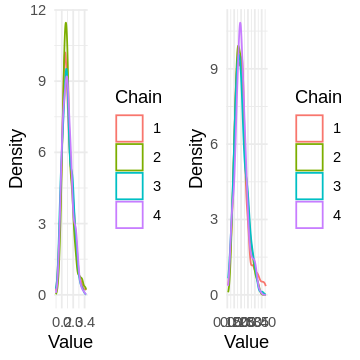

In [ ]:
library(ggplot2)
library(reshape2)
library(gridExtra)

# Assuming 'fits' is a list of your Stan model fit objects
# Extract sigma samples from the first model fit for simplicity
sigma_samples <- as.array(fits[[1]], pars = "sigma")

# Combine the samples into a single data frame
sigma_df <- as.data.frame(sigma_samples)

# Rename columns for clarity
colnames(sigma_df) <- paste0("sigma ", 1:ncol(sigma_df))

# Convert the samples to long format for ggplot using melt
samples_long <- melt(sigma_df)

# Rename columns for better readability
colnames(samples_long) <- c("parameter", "value")

# Add an iteration column for the trace plot
samples_long$iteration <- rep(1:nrow(sigma_df), times = ncol(sigma_df))

# Create a list to store plots
plots_list <- list()

# Define the number of chains
num_chains <- 4

# Define the specific sigma parameters to plot
sigma_parameters <- c("sigma 1", "sigma 2")

# Loop through the specific sigma parameters
for (param in sigma_parameters) {
  # Filter samples for the parameter
  parameter_samples <- subset(samples_long, parameter == param)

  # Add chain number to samples
  parameter_samples$chain <- rep(1:num_chains, each = nrow(parameter_samples) / num_chains)

  # Create density plot for the parameter
  density_plot <- ggplot(parameter_samples, aes(x = value, color = factor(chain))) +
    geom_density(size = 0.5) +
    labs(x = "Value", y = "Density", color = "Chain") +
    theme_minimal()

  # Add the density plot to the list
  plots_list[[param]] <- density_plot
}

# Combine plots into a grid
grid_plots <- grid.arrange(grobs = plots_list, ncol = 2)

# Display the grid of plots
print(grid_plots)


In [ ]:
ggsave("density_sigmoid_fit1_normal.png", plot = grid_plots, width = 5, height = 3, dpi = 300)

 ### Modifying theta parameters


First, let's look at the distributions we are considering

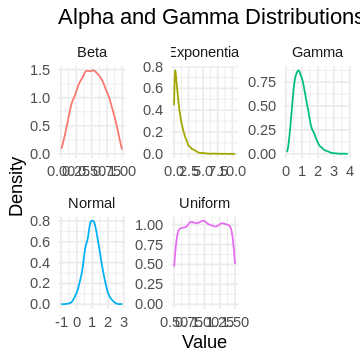

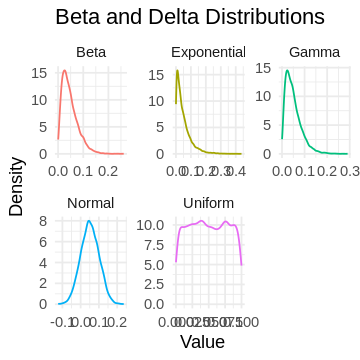

In [19]:
n_samples <- 10000

# Generate samples for alpha distributions
alpha_samples <- list(
  rnorm(n_samples, 1, 0.5),
  rgamma(n_samples, 4, 4),
  rbeta(n_samples, 2, 2),
  rexp(n_samples, 1),
  runif(n_samples, 0.5, 1.5)
)

# Generate samples for beta distributions
beta_samples <- list(
  rnorm(n_samples, 0.05, 0.05),
  rgamma(n_samples, 2, 40),
  rbeta(n_samples, 2, 40),
  rexp(n_samples, 20),
  runif(n_samples, 0, 0.1)
)

distributions <- c(rep("Normal", n_samples), rep("Gamma", n_samples),
                   rep("Beta", n_samples), rep("Exponential", n_samples), rep("Uniform", n_samples))

alpha_df <- data.frame(value = unlist(alpha_samples), distribution = distributions)
beta_df <- data.frame(value = unlist(beta_samples), distribution = distributions)

# Plot alpha distributions
alpha_plot <- ggplot(alpha_df, aes(x = value, color = distribution)) +
  geom_density() +
  facet_wrap(~ distribution, scales = "free") +
  labs(title = "Alpha and Gamma Distributions", x = "Value", y = "Density") +
  theme_minimal() +
  theme(legend.position = "none")

# Plot beta distributions
beta_plot <- ggplot(beta_df, aes(x = value, color = distribution)) +
  geom_density() +
  facet_wrap(~ distribution, scales = "free") +
  labs(title = "Beta and Delta Distributions", x = "Value", y = "Density") +
  theme_minimal() +
  theme(legend.position = "none")

# Save the plots
ggsave("alpha_distributions.png", plot = alpha_plot, width = 7, height = 4, dpi = 300)
ggsave("beta_distributions.png", plot = beta_plot, width = 7, height = 4, dpi = 300)

print(alpha_plot)
print(beta_plot)

We will start with the original model and apply some modifications

In [20]:
# Original model
scode <- "
functions {
  array[] real dz_dt(real t, // time
                     array[] real z,
                     // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N] real ts; // measurement times > 0
  array[2] real y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  array[4] real<lower=0> theta; // { alpha, beta, gamma, delta }
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}
transformed parameters {
  array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}"

In [21]:
N <- length(lynx_hare_df$Year) - 1
ts <- 1:N
y_init <- c(lynx_hare_df$Hare[1], lynx_hare_df$Lynx[1])
y <- as.matrix(lynx_hare_df[2:(N + 1), 2:3])
y <- cbind(y[ , 2], y[ , 1]); # hare, lynx order
lynx_hare_data <- list(N = N, ts = ts, y_init = y_init, y = y)

In [22]:
# Define new distributions to test
distributions_alpha <- c(
  "theta[{1, 3}] ~ normal(1, 0.5);",
  "theta[{1, 3}] ~ gamma(4, 4);",
  "theta[{1, 3}] ~ beta(2, 2);",
  "theta[{1, 3}] ~ exponential(1);"
)

distributions_beta <- c(
  "theta[{2, 4}] ~ normal(0.05, 0.05);",
  "theta[{2, 4}] ~ gamma(2, 40);",
  "theta[{2, 4}] ~ beta(2, 40);",
  "theta[{2, 4}] ~ exponential(20);"
)

In [23]:
# Iterate over the different distributions and save their results

thetas_list <- list()
zinit_list <- list()
fits <- list()
# Iterate over the tests
for (i in 1:length(distributions_alpha)) {
  alpha_dist <- distributions_alpha[i]
  beta_dist <- distributions_beta[i]

  # Modify the distributions
  modified_scode <- scode
  modified_scode <- gsub("theta\\[\\{1, 3\\}\\] ~ normal\\(1, 0.5\\);",
                         alpha_dist,
                         modified_scode)
  modified_scode <- gsub("theta\\[\\{2, 4\\}\\] ~ normal\\(0.05, 0.05\\);",
                         beta_dist,
                         modified_scode)

  # Compile the model
  model <- stan_model(model_code = modified_scode)

  # Fit the model
  fit <- sampling(model, data = lynx_hare_data, seed = 123)
  fits[[i]] <- fit

  # Print fit summary
  print(fit, pars=c("theta", "sigma", "z_init"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

  # Save the results
  thetas_list[[i]] <- extract(fit)$theta
  zinit_list[[i]] <- extract(fit)$z_init
}

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.546   0.002 0.065  0.465  0.544  0.630  1011 1.002
theta[2]   0.028   0.000 0.004  0.023  0.027  0.033  1077 1.003
theta[3]   0.802   0.003 0.093  0.688  0.796  0.920   977 1.003
theta[4]   0.024   0.000 0.004  0.020  0.024  0.029  1026 1.003
sigma[1]   0.249   0.001 0.044  0.199  0.243  0.307  2685 1.000
sigma[2]   0.250   0.001 0.044  0.202  0.244  0.306  2662 1.000
z_init[1] 33.984   0.054 2.918 30.353 33.907 37.897  2952 1.001
z_init[2]  5.946   0.011 0.524  5.305  5.917  6.621  2177 0.999

Samples were drawn using NUTS(diag_e) at Wed Jun 12 20:11:44 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model.

Warning message:
“There were 4 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.562   0.002 0.057  0.491  0.558  0.634  1008 1.006
theta[2]   0.029   0.000 0.004  0.024  0.028  0.034  1154 1.005
theta[3]   0.775   0.002 0.073  0.685  0.774  0.870  1058 1.006
theta[4]   0.023   0.000 0.003  0.020  0.023  0.027  1168 1.003
sigma[1]   0.249   0.001 0.044  0.200  0.244  0.305  2438 1.001
sigma[2]   0.251   0.001 0.044  0.201  0.246  0.309  2953 1.000
z_init[1] 34.243   0.054 3.066 30.467 34.177 38.134  3262 1.000
z_init[2]  6.003   0.012 0.522  5.363  5.967  6.670  2003 1.003

Samples were drawn using NUTS(diag_e) at Wed Jun 12 20:19:19 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model.

In [24]:
# For the uniform distribution we need some additional changes
uniform_scode <- "
functions {
  array[] real dz_dt(real t, // time
                     array[] real z,
                     // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N] real ts; // measurement times > 0
  array[2] real y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  real<lower=0.5, upper=1.5> alpha;  // alpha with bounds [0.5, 1.5]
  real<lower=0, upper=0.1> beta;     // beta with bounds [0, 0.1]
  real<lower=0.5, upper=1.5> gamma;  // gamma with bounds [0.5, 1.5]
  real<lower=0, upper=0.1> delta;    // delta with bounds [0, 0.1]
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}

transformed parameters {
  array[4] real theta; // Combined array { alpha, beta, gamma, delta }
  theta[1] = alpha;
  theta[2] = beta;
  theta[3] = gamma;
  theta[4] = delta;

  array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                             rep_array(0.0, 0), rep_array(0, 0),
                                             1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ uniform(0.5, 1.5);
  theta[{2, 4}] ~ normal(0, 0.1);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}"

model <- stan_model(model_code = uniform_scode)

fit <- sampling(model, data = lynx_hare_data, seed = 123)
fits[[i+1]] <- fit

print(fit, pars=c("theta", "sigma", "z_init"),
    probs=c(0.1, 0.5, 0.9), digits = 3)

thetas_list[[i+1]] <- extract(fit)$theta
zinit_list[[i+1]] <- extract(fit)$z_init

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.569   0.002 0.048  0.512  0.562  0.634   729 1.004
theta[2]   0.029   0.000 0.004  0.025  0.029  0.034   819 1.003
theta[3]   0.766   0.002 0.062  0.682  0.769  0.846   797 1.003
theta[4]   0.023   0.000 0.003  0.020  0.023  0.026   870 1.004
sigma[1]   0.245   0.001 0.042  0.197  0.240  0.298  1619 1.001
sigma[2]   0.250   0.001 0.043  0.201  0.244  0.306  1983 1.001
z_init[1] 34.104   0.064 2.857 30.565 34.037 37.721  1993 1.001
z_init[2]  6.006   0.013 0.508  5.397  5.974  6.656  1638 1.000

Samples were drawn using NUTS(diag_e) at Wed Jun 12 20:26:55 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now let'e evaluate the results

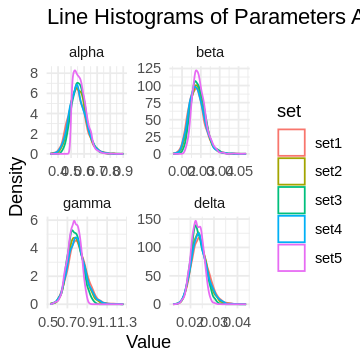

In [25]:
# Then we show the fitted distributions

combined_thetas_df <- data.frame()

# Save the results in a dataframe
for (i in seq_along(thetas_list)) {
  thetas_df <- as.data.frame(thetas_list[[i]])
  colnames(thetas_df) <- c("alpha", "beta", "gamma", "delta")
  thetas_df$set <- paste0("set", i)
  combined_thetas_df <- dplyr::bind_rows(combined_thetas_df, thetas_df)
}

# Melt the df
combined_thetas_melted <- reshape2::melt(combined_thetas_df, id.vars = "set")

# Plot density lines for each parameter across different distributions
lines <- ggplot(combined_thetas_melted, aes(x = value, color = set)) +
  geom_density() +
  facet_wrap(~ variable, scales = "free") +
  labs(title = "Line Histograms of Parameters Across Different Distributions",
       x = "Value",
       y = "Density") +
  theme_minimal()

ggsave("lines.png", plot = lines, width = 10, height = 6, dpi = 300)

lines

In [26]:
# Now, let's make a table with the estimated parameters
# and compare them to our reference using the euclidean distance

# The reference values from the paper
reference <- c(alpha = 0.55, beta = 0.028, gamma = 0.84, delta = 0.026)

means_df <- data.frame(set = character(), alpha = numeric(), beta = numeric(), gamma = numeric(), delta = numeric())

for (i in seq_along(thetas_list)) {
  thetas_df <- as.data.frame(thetas_list[[i]])
  colnames(thetas_df) <- c("alpha", "beta", "gamma", "delta")

  # Calculate the mean of each parameter
  means <- colMeans(thetas_df)
  means_df <- rbind(means_df, data.frame(set = paste0("set", i), t(means)))
}

# Add the reference row
means_df <- rbind(means_df, data.frame(set = "reference", t(reference)))

# Calculate the Euclidean distance
means_df$euclidean_distance <- sqrt((means_df$alpha - reference["alpha"])^2 +
                                    (means_df$beta - reference["beta"])^2 +
                                    (means_df$gamma - reference["gamma"])^2 +
                                    (means_df$delta - reference["delta"])^2)

print(means_df)

# Save the table to a CSV file
write.csv(means_df, "theta_means_and_distances.csv", row.names = FALSE)

        set     alpha       beta     gamma      delta euclidean_distance
1      set1 0.5463612 0.02767999 0.8016689 0.02416330         0.03854851
2      set2 0.5528420 0.02812879 0.7908872 0.02375394         0.04924638
3      set3 0.5615432 0.02862592 0.7751996 0.02318254         0.06588379
4      set4 0.5498255 0.02786482 0.7945136 0.02381079         0.04553961
5      set5 0.5689974 0.02902932 0.7664628 0.02282393         0.07602479
6 reference 0.5500000 0.02800000 0.8400000 0.02600000         0.00000000


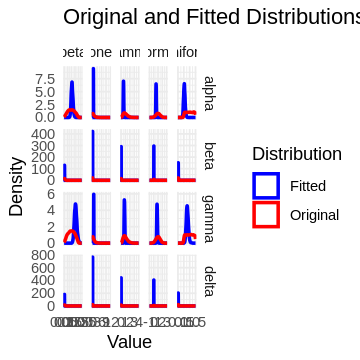

In [27]:
# Finally, let's print the original distribution and the fitted one together

# Define original distributions
original_distributions_alpha <- list(
  uniform = runif(10000, 0.5, 1.5),
  normal = rnorm(10000, 1, 0.5),
  gamma = rgamma(10000, shape = 4, rate = 4),
  beta = rbeta(10000, 2, 2),
  exponential = rexp(10000, rate = 1)
)

original_distributions_beta <- list(
  uniform = runif(10000, 0, 0.05),
  normal = rnorm(10000, 0.05, 0.05),
  gamma = rgamma(10000, shape = 2, rate = 40),
  beta = rbeta(10000, 2, 40),
  exponential = rexp(10000, rate = 20)
)

original_distributions_gamma <- list(
  uniform = runif(10000, 0.5, 1.5),
  normal = rnorm(10000, 1, 0.5),
  gamma = rgamma(10000, shape = 4, rate = 4),
  beta = rbeta(10000, 2, 2),
  exponential = rexp(10000, rate = 1)
)

original_distributions_delta <- list(
  uniform = runif(10000, 0, 0.05),
  normal = rnorm(10000, 0.05, 0.05),
  gamma = rgamma(10000, shape = 2, rate = 40),
  beta = rbeta(10000, 2, 40),
  exponential = rexp(10000, rate = 20)
)

# Combine original distributions into a data frame
original_alpha_df <- data.frame(
  value = unlist(original_distributions_alpha),
  distribution = rep(names(original_distributions_alpha), each = 10000),
  parameter = "alpha"
)

original_beta_df <- data.frame(
  value = unlist(original_distributions_beta),
  distribution = rep(names(original_distributions_beta), each = 10000),
  parameter = "beta"
)

original_gamma_df <- data.frame(
  value = unlist(original_distributions_gamma),
  distribution = rep(names(original_distributions_gamma), each = 10000),
  parameter = "gamma"
)

original_delta_df <- data.frame(
  value = unlist(original_distributions_delta),
  distribution = rep(names(original_distributions_delta), each = 10000),
  parameter = "delta"
)

original_df <- rbind(original_alpha_df, original_beta_df, original_gamma_df, original_delta_df)

# Extract theta samples from thetas_list
theta_names <- c("alpha", "beta", "gamma", "delta")

extract_theta_samples <- function(thetas_list, param_index) {
  theta_values <- sapply(thetas_list, function(thetas) {
    as.numeric(thetas[, param_index])
  })
  melted <- melt(theta_values)
  colnames(melted) <- c("sample", "distribution", "value")
  return(melted)
}

theta_alpha_samples <- extract_theta_samples(thetas_list, 1)
theta_beta_samples <- extract_theta_samples(thetas_list, 2)
theta_gamma_samples <- extract_theta_samples(thetas_list, 3)
theta_delta_samples <- extract_theta_samples(thetas_list, 4)

# Combine fitted distributions into a data frame
fitted_alpha_df <- data.frame(
  value = theta_alpha_samples$value,
  distribution = rep(names(original_distributions_alpha), each = nrow(theta_alpha_samples)/length(original_distributions_alpha)),
  parameter = "alpha"
)

fitted_beta_df <- data.frame(
  value = theta_beta_samples$value,
  distribution = rep(names(original_distributions_beta), each = nrow(theta_beta_samples)/length(original_distributions_beta)),
  parameter = "beta"
)

fitted_gamma_df <- data.frame(
  value = theta_gamma_samples$value,
  distribution = rep(names(original_distributions_gamma), each = nrow(theta_gamma_samples)/length(original_distributions_gamma)),
  parameter = "gamma"
)

fitted_delta_df <- data.frame(
  value = theta_delta_samples$value,
  distribution = rep(names(original_distributions_delta), each = nrow(theta_delta_samples)/length(original_distributions_delta)),
  parameter = "delta"
)

fitted_df <- rbind(fitted_alpha_df, fitted_beta_df, fitted_gamma_df, fitted_delta_df)
fitted_df$source <- "Fitted"

# Combine original and fitted data frames
original_df$source <- "Original"
combined_df <- rbind(original_df, fitted_df)

# Specify order of parameter factor levels
combined_df$parameter <- factor(combined_df$parameter, levels = c("alpha", "beta", "gamma", "delta"))

# Plot the combined distributions
plot_combined <- ggplot(combined_df, aes(x = value, color = source, linetype = source)) +
  geom_density(size = 1) +
  facet_grid(parameter ~ distribution, scales = "free") +
  labs(title = "Original and Fitted Distributions of Parameters",
       x = "Value",
       y = "Density",
       color = "Distribution",
       linetype = "Distribution") +
  theme_minimal() +
  scale_color_manual(values = c("Original" = "red", "Fitted" = "blue")) +
  scale_linetype_manual(values = c("Original" = "solid", "Fitted" = "solid"))

# Save the plot
ggsave("combined_distributions.png", plot = plot_combined, width = 14, height = 7, dpi = 300)

print(plot_combined)

## The competitive Lotka-Volterra equations

In [ ]:
competitive_stan <- "functions {
  array[] real dz_dt(real t, // time
                     array[] real z, // system state {prey, predator}
                     array[] real theta, // parameters
                     array[] real x_r, // unused data
                     array[] int x_i) {
    real u = z[1];
    real v = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];
    real nu1 = theta[5];
    real nu2 = theta[6];

    real du_dt = alpha * u * (1 - (u / nu1)) - beta * u * v;
    real dv_dt = gamma * v * (1 - (v / nu2)) - delta * u * v;
    return {du_dt, dv_dt};
  }
}
data {
  int<lower=0> N; // number of measurement times
  array[N] real ts; // measurement times > 0
  array[2] real<lower=0> y_init; // initial measured populations
  array[N, 2] real<lower=0> y; // measured populations
}
parameters {
  array[6] real<lower=0> theta; // {ru, Ku, alpha, rv, Kv, beta}
  array[2] real<lower=0> z_init; // initial population
  array[2] real<lower=0> sigma; // measurement errors
}
transformed parameters {
  array[N, 2] real<lower=0> z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  theta[5] ~ uniform(65, 85);
  theta[6] ~ uniform(45, 65);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}
generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}"

In [ ]:
model2 <- stan_model(model_code=competitive_stan)

In [ ]:
fit <- sampling(model2, data = lynx_hare_data, seed = 123, chains=1)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: lognormal_lpdf: Location parameter[5] is -nan, but must be finite! (in 'anon_model', line 48, column 4 to column 52)
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: lognormal_lpdf: Location parameter[2] is -nan, but must be finite! (in 'anon_model', line 48, column 4 to column 52)
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: lognormal_lpdf: Location parameter[3] is -nan, but must be finite! (in 'anon_model', line 48, column 4 to column 52)
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating

error occurred during calling the sampler; sampling not done

